In [1]:
%matplotlib inline

# K-moyennes (jeu des Iris)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn_extra.cluster import KMedoids
from scipy.spatial import distance

In [3]:
# options pour pandas
pd.set_option("display.max_columns",30)
pd.set_option('display.max_rows', 30)

In [4]:
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)


## Prise en main de l'algorithme des Kmeans

**On rappelle que l'algorithme des K-moyennes est un algorithmes non supervisé.**    
Le premier objectif de cette partie est la prise en main de l'algorithme des kmeans sur un jeu de données plus réaliste.    (Cela reste un jeu de données jouet.)    
A priori, il s'agit de reprendre ce qui a déjà été fait précédemment. 
([Une étude très succincte](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html#sphx-glr-auto-examples-cluster-plot-cluster-iris-py) a déjà été réalisée dans un tutoriel.) 

#### Chargement des données

Le jeu de données des Iris de Fisher est un jeu de données classique qui fait partie des jeux de données de référence utilisés par scikit-learn.    
Il contient **un ensemble 132 données en dimension 2**.   
Ce jeu de données, qui a été utilisé pour illustrer le fonctionnement d'un grand nombre d'algorithme a entre autres [une description sur wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set).    
 Ce jeu de données contient les classes de chacun des individus, on se servira de cela pour discuter la partition obtenue à l'aide de l'algorithme des k-moyennes.    
Là encore les dimensions du problème n sont pas réellement limitantes (Il est possible de trouver une projection en 2D permettant d'obtenir une visualisation du problème relativement bonne.)  
**Pour un problème réaliste, les données seront pas nécessairement projetables dans un espace de dimension deux, on ne pourra pas se servir de visualisations comme cela serait possible ici. Ces éventuelles visualisations ne seront là que pour aider à comprendre l'algorithme ou le jeu de données. Pour indiquer, un nombre "optimal" de classe on devra le justifier en se basant au minimum sur un indicateur et des explications.**    

In [5]:
# pour charger les données, on recommande l'utilisation de pandas 
# qui est en général utilsé pour une description statistiques rapide des données 
# (ici, cela ne sera pas nécessaire)
# néanmoins l'utilisation d'autre chose reste votre prérogative
(data,target) = datasets.load_iris(return_X_y=True)
nomDesVariables = ['hauteur sépale','largeur sépale','hauteur pétale','largeur pétale']
# hauteur et la largeur du sépale (HS et LS), la hauteur et la largeur du pétale (HP et LP).

**Attention, il y a un doublon dans les donnees.**

In [6]:
a,ind,ind_rev=np.unique(data,axis=0,return_index=True,return_inverse=True)
data[np.where(ind_rev==76),:], target[np.where(ind_rev==76)]
# On supprime le doublon
# 
data = data[ind]
target = target[ind]
#
# On met en forme les données.
Data1 = pd.DataFrame(data,columns=nomDesVariables)

#### Classification kmeans

Le script ci-dessous utilise les données Data1 pour illustrer l'algorithme des k-moyennes. 
L'affichage résultant correspond à une projection en 2D de l'espace orginal. 
**Exécuter ce script et expliquer les résultats.**

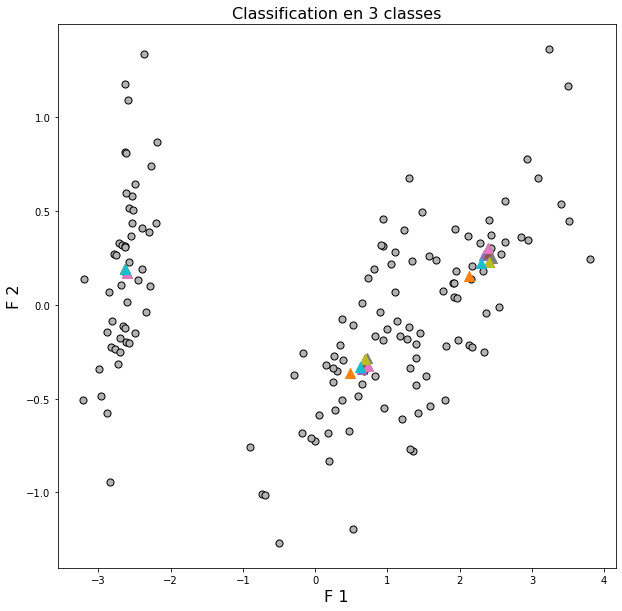

In [7]:
# préparation du jeu de données
Data = Data1.values

# nombre de centres retenu
n_clusters=3

# projection des donnees 
pca = PCA(n_components=2)
pca.fit(Data)
X_pca = pca.transform(Data)

#
# affichage des points ayant servis pour adapter le modèle.
plt.figure(figsize=(10,10))
plt.scatter(X_pca[:,0],X_pca[:,1], facecolor=[.7,.7,.7], edgecolor='k', s=50)
plt.xlabel('F 1',fontsize=16)
plt.ylabel('F 2',fontsize=16)

plt.title("Classification en {0} classes".format(n_clusters),
          fontsize=16)

# paramétrage de l'algorithme
k_means=KMeans(n_clusters=n_clusters,max_iter=1)

e=(0.2, 0.9, 0.1)

# boucle sur les apprentissages
for n_iter in range(10):
    # apprentissage 
    k_means.fit(Data)
    # projection des centres
    centers_pca = pca.transform(k_means.cluster_centers_)
    # affichage des centres projetés
    plt.scatter(centers_pca [:,0],centers_pca [:,1],
               marker='^', s=100)


## Choix des paramètres de l'algorithme 

Objectif : 
- Impact du nombre de classes sur les performance de l'algorithme.
- Impact de la distance et du système de poids lors du vote.

Le script ci-dessous compare des classification type kmeans avec plusierus valeurs de k

In [8]:
# liste_n_clusters donne le nbre de clusters considérés dans chaque expérience
liste_n_clusters=[1, 2, 3, 4, 5, 8, 10, 15, 20, Data.shape[0]//2,  Data.shape[0]]

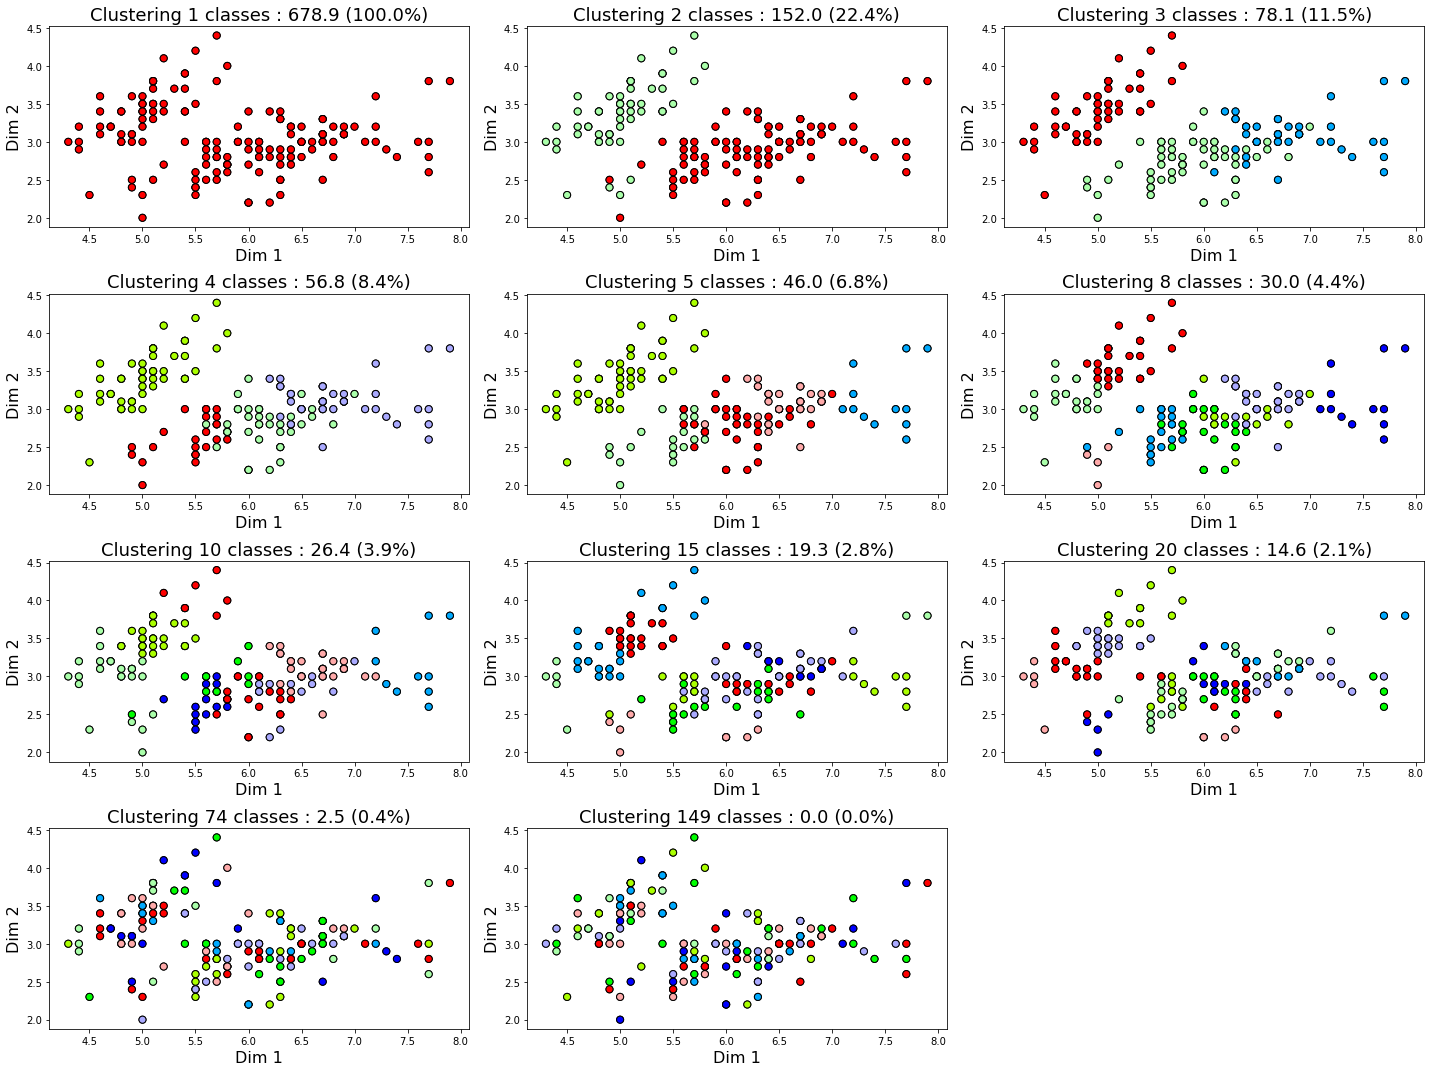

In [9]:
# a reprendre
from matplotlib.colors import ListedColormap
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#AAFF00','#0000FF', 
                             '#00AAFF', '#AAAAFF','#FFAAAA', '#AAFFAA'])

inerties_intra = list()
bic_clusters = list()
silhouette_avg = list()
silhouette_sample_values = list()
agregat_label = [[]]*len(liste_n_clusters)
agregat_cardinalite = [[]]*len(liste_n_clusters)
states={}

nb_c = 3
nb_l = int(np.ceil(len(liste_n_clusters)/nb_c))
figure = plt.figure(figsize=(20, 15))
for i,n_clusters in enumerate(liste_n_clusters):
    # création du modèle de classification
    k_means=KMeans(n_clusters=n_clusters)
    k_means.fit(Data)
    #
    # calcul de l'inertie intra classes
    if n_clusters==1:
        inertie_totale= k_means.inertia_
    inertie_intra_=100 * k_means.inertia_ / inertie_totale
    inerties_intra.append(k_means.inertia_)
    #
    # Calcul du BIC de la partition
    if n_clusters!=1 and n_clusters!=Data.shape[0]:
        bic_clusters.append(compute_bic(k_means,Data))

    #
    # Calcul du coefficient de silhouette 
    #  (silhouette_score gives the average value for all the samples)
    if n_clusters!=1 and n_clusters!=Data.shape[0]:
        silhouette_avg.append(silhouette_score(Data, k_means.labels_))
        silhouette_sample_values.append(silhouette_samples(Data, k_means.labels_))
    #
    # cardinalites des differents aggegats
    agregat_label[i], agregat_cardinalite[i] = np.unique(k_means.labels_, return_counts=True)
    #
    # affichage des points ayant servis pour la classification
    #  (colorés en fonction des clusters)
    ax=plt.subplot(nb_l,nb_c,i+1)
    ax.scatter(Data[:, 0], Data[:, 1], c=k_means.labels_,
               cmap=cmap_bold, edgecolor='k', s=50)
    ax.scatter(Data[:, 0], Data[:, 1], c=k_means.labels_,
               cmap=cmap_bold, edgecolor='k', s=50)
    # titres et autres 
    plt.title("Clustering {} classes : {:.1f} ({:.1f}%)".format(n_clusters,inerties_intra[-1],inertie_intra_),fontsize=18)
    plt.xlabel('Dim 1',fontsize=16)
    plt.ylabel('Dim 2',fontsize=16)
    
    states[n_clusters]=k_means.__getstate__().copy()
plt.tight_layout()

#### Cardinalités

In [10]:
tableau_cardinalite = np.zeros((len(liste_n_clusters),max(liste_n_clusters)))
for i, lesCard in enumerate(agregat_cardinalite):
    for j, card in enumerate(lesCard): 
        tableau_cardinalite[i][j] = card
df = pd.DataFrame(tableau_cardinalite,columns= agregat_label[-1]) 
df = df.applymap("{0:.0f}".format)
df[df.eq('0')] = ''
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148
0,149,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,
1,96,53,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,
2,50,38,61,,,,,,,,,,,,,...,,,,,,,,,,,,,,,
3,28,50,32,39,,,,,,,,,,,,...,,,,,,,,,,,,,,,
4,38,50,12,24,25,,,,,,,,,,,...,,,,,,,,,,,,,,,
5,28,18,19,12,24,22,4,22,,,,,,,,...,,,,,,,,,,,,,,,
6,7,14,10,24,19,10,18,24,4,19,,,,,,...,,,,,,,,,,,,,,,
7,18,21,9,13,8,11,8,7,17,12,10,4,4,5,2,...,,,,,,,,,,,,,,,
8,8,15,3,3,9,12,8,5,4,10,2,8,9,6,17,...,,,,,,,,,,,,,,,
9,1,6,1,3,4,3,2,2,4,1,1,2,2,3,3,...,,,,,,,,,,,,,,,


#### Analyse de la variance (inertie intra)

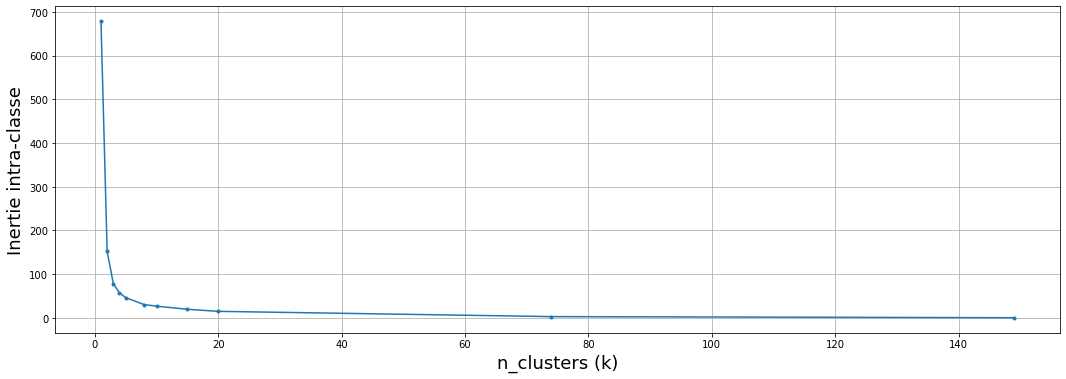

In [11]:
plt.figure(figsize=(18,6))
plt.plot(liste_n_clusters[::-1],inerties_intra[::-1],'.-')
plt.grid()
plt.xlabel('n_clusters (k)',fontsize=18)
plt.ylabel('Inertie intra-classe',fontsize=18) ;

#### BIC pour différents nombres de centres 

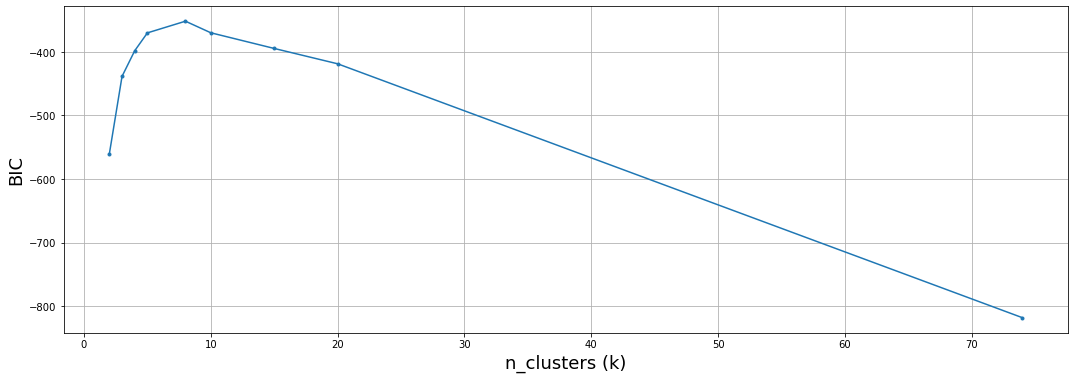

In [12]:
plt.figure(figsize=(18,6))
plt.plot(liste_n_clusters[-2:0:-1],bic_clusters[::-1],'.-')
plt.grid()
plt.xlabel('n_clusters (k)',fontsize=18)
plt.ylabel('BIC',fontsize=18) ;

#### Coefficient de Silhouette
(Pour cette partie on pourra voir la définition du [coefficient de Silhouette](https://fr.wikipedia.org/wiki/Silhouette_(clustering)) sur wikipedia ainsi que la documentation sur le site de scikit learn pour laquelle il y a un [tutoriel sur kmoyennes et silouhette](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html))    
En partitionnement de données (clustering), le coefficient de silhouette est une mesure de qualité d'une partition d'un ensemble de données en classification automatique. Pour chaque point, son coefficient de silhouette est la différence entre la distance moyenne avec les points du même groupe que lui (cohésion) et la distance moyenne avec les points des autres groupes voisins (séparation). Si cette différence est négative, le point est en moyenne plus proche du groupe voisin que du sien : il est donc mal classé. A l'inverse, si cette différence est positive, le point est en moyenne plus proche de son groupe que du groupe voisin : il est donc bien classé.

Le coefficient de silhouette proprement dit est la moyenne du coefficient de silhouette pour tous les points. 

Text(0, 0.5, 'Inertie intra-classe')

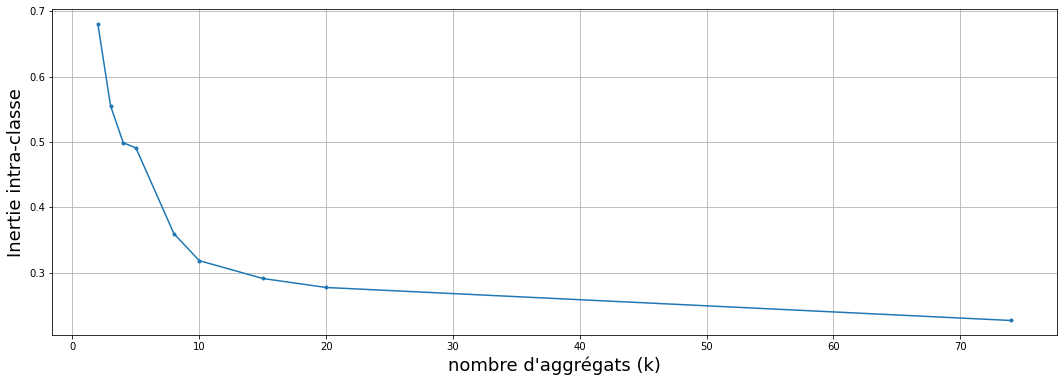

In [13]:
plt.figure(figsize=(18,6))
plt.plot(liste_n_clusters[-2:0:-1],silhouette_avg[::-1],'.-')
plt.grid()
plt.xlabel('''nombre d'aggrégats (k)''',fontsize=18)
plt.ylabel('Inertie intra-classe',fontsize=18)

#### Formes fortes 

Une forme forte identifie les observations qui sont toujours affectées au même cluster quelques soit l'essai

In [14]:
n_essais=20
n_clusters=3
Memory=np.zeros((Data.shape[0],n_essais))
for i in range(n_essais):
    k_means=KMeans(n_clusters)
    k_means.fit(Data)
    Memory[:,i]=k_means.labels_

##### Les données et les classes associées (pour différentes initialisations)

In [15]:
pd.DataFrame(Memory.astype(int),index=['d'+str(i+1) for i in range(Data.shape[0])],columns=[str(i) for i in range(n_essais)])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
d1,0,1,1,0,0,1,1,0,0,1,1,1,1,0,0,1,0,1,1,1
d2,0,1,1,0,0,1,1,0,0,1,1,1,1,0,0,1,0,1,1,1
d3,0,1,1,0,0,1,1,0,0,1,1,1,1,0,0,1,0,1,1,1
d4,0,1,1,0,0,1,1,0,0,1,1,1,1,0,0,1,0,1,1,1
d5,0,1,1,0,0,1,1,0,0,1,1,1,1,0,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d145,2,2,0,1,2,2,0,2,2,0,2,2,2,2,1,2,1,0,0,2
d146,2,2,0,1,2,2,0,2,2,0,2,2,2,2,1,2,1,0,0,2
d147,2,2,0,1,2,2,0,2,2,0,2,2,2,2,1,2,1,0,0,2
d148,2,2,0,1,2,2,0,2,2,0,2,2,2,2,1,2,1,0,0,2


##### Les formes fortes résultantes 

In [16]:
formes_fortes, unique_counts=np.unique(Memory,axis=0, return_counts=True)
nombreDeFormesFortes = formes_fortes.shape[0]
pd.DataFrame(formes_fortes.astype(int),
             index=[ 'FF {} ({:2})'.format(i+1,c) for i,c in enumerate(unique_counts)],
             columns=[str(i) for i in range(n_essais)])
#pd.DataFrame(formes_fortes,columns=[str(i) for i in range(n_essais)])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
FF 1 (50),0,1,1,0,0,1,1,0,0,1,1,1,1,0,0,1,0,1,1,1
FF 2 (61),1,0,2,2,1,0,2,1,1,2,0,0,0,1,2,0,2,2,2,0
FF 3 (38),2,2,0,1,2,2,0,2,2,0,2,2,2,2,1,2,1,0,0,2


## Pour aller plus loin ? la CAH ?
(Pour utiliser l'algorithme des [CAH](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram), il faut charger le module "**sklearn_extra**".    
On pourra aussi regarder cette [démonstration](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html).)

In [17]:
# à faire

## Pour aller plus loin ? les K-médoïdes ?
(Pour utiliser l'algorithme des [k-médoïdes](https://en.wikipedia.org/wiki/K-medoids), il faut charger le module "**sklearn_extra**".    
On pourra aussi regarder cette [démonstration](https://scikit-learn-extra.readthedocs.io/en/latest/auto_examples/plot_kmedoids_digits.html#sphx-glr-auto-examples-plot-kmedoids-digits-py).)

In [18]:
# là aussi.

## L'informations des classes sont-elles ressorties ?
A l'aide des différents algorithmes non supervisés, on a obtenu une partition du jeu de données. Ici, on va comparer le résultats de ces différentes classifications avec celle des données originales `target`.    
Pour cela on pourra utiliser un indice de rand : 
 - [Indice de Rand sur scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)

 - [Indice de Rand sur wikipedia](https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index)

In [19]:
# là aussi.

***
**On est jamais mieux servi que par soi-même.**  
**If you want something done right, do it yourself.**

[pandas](https://pandas.pydata.org/) - [Numpy and Scipy](https://docs.scipy.org/doc/) - [matplotlib](https://matplotlib.org/) - [scikit-learn](http://scikit-learn.org/stable/) - [seaborn](https://seaborn.pydata.org/)